# 測試與使用訓練好的Model

先安裝mmdetection

In [1]:
!python -m pip install --upgrade pip
!pip install openmim what-a-dict
!mim install mmdet==2.24.1

     |████████████████████████████████| 82 kB 135 kB/s eta 0:00:01
  Created wheel for openmim: filename=openmim-0.1.5-py2.py3-none-any.whl size=42502 sha256=0baa01dc0f9f9238cc589df55c6a843aa9a3aaaf015b93955a256553480373e7
  Stored in directory: /home/jovyan/.cache/pip/wheels/16/8b/e1/bdebbbc687aa50224a5ce46fe97a040a0c59f92b34bfc750b6
Successfully built openmim
  Attempting uninstall: Click
    Found existing installation: click 8.0.1
    Uninstalling click-8.0.1:
      Successfully uninstalled click-8.0.1
installing mmdet from https://github.com/open-mmlab/mmdetection.git.
Cloning into '/tmp/tmpjjcx7jzb/mmdetection'...
remote: Enumerating objects: 24787, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 24787 (delta 1), reused 5 (delta 0), pack-reused 24771
Receiving objects: 100% (24787/24787), 37.71 MiB | 14.00 MiB/s, done.
Resolving deltas: 100% (17364/17364), done.
Note: checking out '73b4e65a6a30435ef6a35f405e3474a4

clone 我們的 github repo

In [ ]:
!git clone https://github.com/ShuYuHuang/pisa-simple-example.git
%cd pisa-simple-example

沒資料的話請下載資料

In [ ]:
!mkdir -p data/coco
!curl -L "https://public.roboflow.com/ds/teSUuBdtOy?key=MSfxYe5Fz3" > data/coco/roboflow.zip
!unzip -o data/coco/roboflow.zip -d data/coco
!rm -rf data/coco/roboflow.zip

如果在Colab上可以下載pre-train好的weight檔

In [ ]:
!gdown https://drive.google.com/u/1/uc?id=1-FD4omWAO0_AAGQRZJHNPXNmlSU281GS&export=download
!tar zxvf pre_trained.tar.gz

## Testing PISA result

In [3]:
# 最簡單來個config檔就結束了
# python tools/test.py config檔.py weight檔.pth --eval {bbox或者proposal(一樣)}
!python tools/test.py pisa_chess.py work_dirs/pisa_chess/latest.pth --eval bbox

/opt/conda/lib/python3.7/site-packages/mmdet/utils/setup_env.py:39: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/opt/conda/lib/python3.7/site-packages/mmdet/utils/setup_env.py:49: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
load checkpoint from local path: work_dirs/pisa_chess/latest.pth
[                                                  ] 0/29, elapsed: 0s, ETA:/opt/conda/lib/python3.7/site-packages/torch/nn/functional.p

In [4]:
# 也看一下沒有加PISA的結果
!python tools/test.py fasterrcnn_chess.py work_dirs/fasterrcnn_chess/latest.pth --eval bbox

/opt/conda/lib/python3.7/site-packages/mmdet/utils/setup_env.py:39: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/opt/conda/lib/python3.7/site-packages/mmdet/utils/setup_env.py:49: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
load checkpoint from local path: work_dirs/fasterrcnn_chess/latest.pth
[                                                  ] 0/29, elapsed: 0s, ETA:/opt/conda/lib/python3.7/site-packages/torch/nn/functi

COCO dataset中各種detector套用PISA之後的AP:

<img src=https://i.imgur.com/lqfjziK.png  width="600">

## Inference

In [5]:
from mmdet.apis import init_detector, inference_detector
pisa_settings=dict(
    config = 'pisa_chess.py',
    checkpoint ="work_dirs/pisa_chess/latest.pth",
    device = 'cuda:0')
nopisa_settings=dict(
    config = 'fasterrcnn_chess.py',
    checkpoint ="work_dirs/fasterrcnn_chess/latest.pth",
    device = 'cuda:0')
# init a detector
model_pisa = init_detector(**pisa_settings)
model_nopisa = init_detector(**nopisa_settings)

load checkpoint from local path: work_dirs/pisa_chess/latest.pth
load checkpoint from local path: work_dirs/fasterrcnn_chess/latest.pth


In [6]:
from glob import glob
from numpy.random import choice
imgs=glob('data/coco/test/*.jpg')
def random_show_inference(*models):
# inference the demo image
    img=choice(imgs)
    for model in models:
        result = inference_detector(model, img)
        list_contents=lambda rs: (model.CLASSES[rs[0]],list(rs[1][:,-1])) if len(rs[1])!=0 else None
        content=[_ for _ in map(list_contents,enumerate(result)) if _!=None]

        print(*content,sep="\n")
        model.show_result(img, result,
                          score_thr=0.2,
                          show=True,
                          text_color=(200, 200, 200),
                          font_size=32)

以上建好可以看inference result的部分

先看一下model內容，主要是feature extractor-> RPN (rpn_head) -> roi pooling (roi_head)

In [7]:
model_pisa

FasterRCNN(
  (backbone): ResNeXt(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

**抽取中間層output來看**

In [8]:
# 使用Hook function 使得model在跑資料時中間層的ouput被儲存下來
import torch.nn as nn
from wad import Dict

class FeatureInspector:
    def __init__(self,net):
        self.submodules=Dict({k:v for k,v in 
                              net._named_members(lambda x:nn.Module.named_modules(x))})
        self.vis=Dict()
    def hook_fn(self,m, i, o):
        self.vis[m.name.replace(".","_")] = o 
    def add_inspection(self,*names):
        
        for n in names:
            for name,layer in self.submodules.items():
                if n == name:
                    print("get", n)
                    layer.name=name
                    layer.register_forward_hook(self.hook_fn)
                    break

In [9]:
fi_pisa=FeatureInspector(model_pisa)
fi_nopisa=FeatureInspector(model_nopisa)

In [10]:
fi_pisa.add_inspection("rpn_head")
fi_pisa.add_inspection("roi_head.bbox_roi_extractor")
fi_pisa.add_inspection("roi_head.bbox_head")

fi_nopisa.add_inspection("rpn_head")
fi_nopisa.add_inspection("roi_head.bbox_roi_extractor")
fi_nopisa.add_inspection("roi_head.bbox_head")

get rpn_head
get roi_head.bbox_roi_extractor
get roi_head.bbox_head
get rpn_head
get roi_head.bbox_roi_extractor
get roi_head.bbox_head


/opt/conda/lib/python3.7/site-packages/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


('black-bishop', [0.99299896, 0.98797196, 0.053685132, 0.052426025])
('black-king', [0.99851936])
('black-knight', [0.9353447, 0.8969137])
('black-pawn', [0.9981831, 0.9974611, 0.99712247, 0.99667597, 0.99591905, 0.99506396, 0.9948185, 0.99337476])
('black-queen', [0.99706763])
('black-rook', [0.9886285, 0.97993237, 0.13601705, 0.10517892])
('white-bishop', [0.99880147, 0.998078])
('white-king', [0.9993018])
('white-knight', [0.9891234, 0.987043])
('white-pawn', [0.9988674, 0.99870265, 0.99853146, 0.99817073, 0.9965168, 0.99623114, 0.9959318, 0.99585056])
('white-queen', [0.9992943])
('white-rook', [0.9975756, 0.99238515])


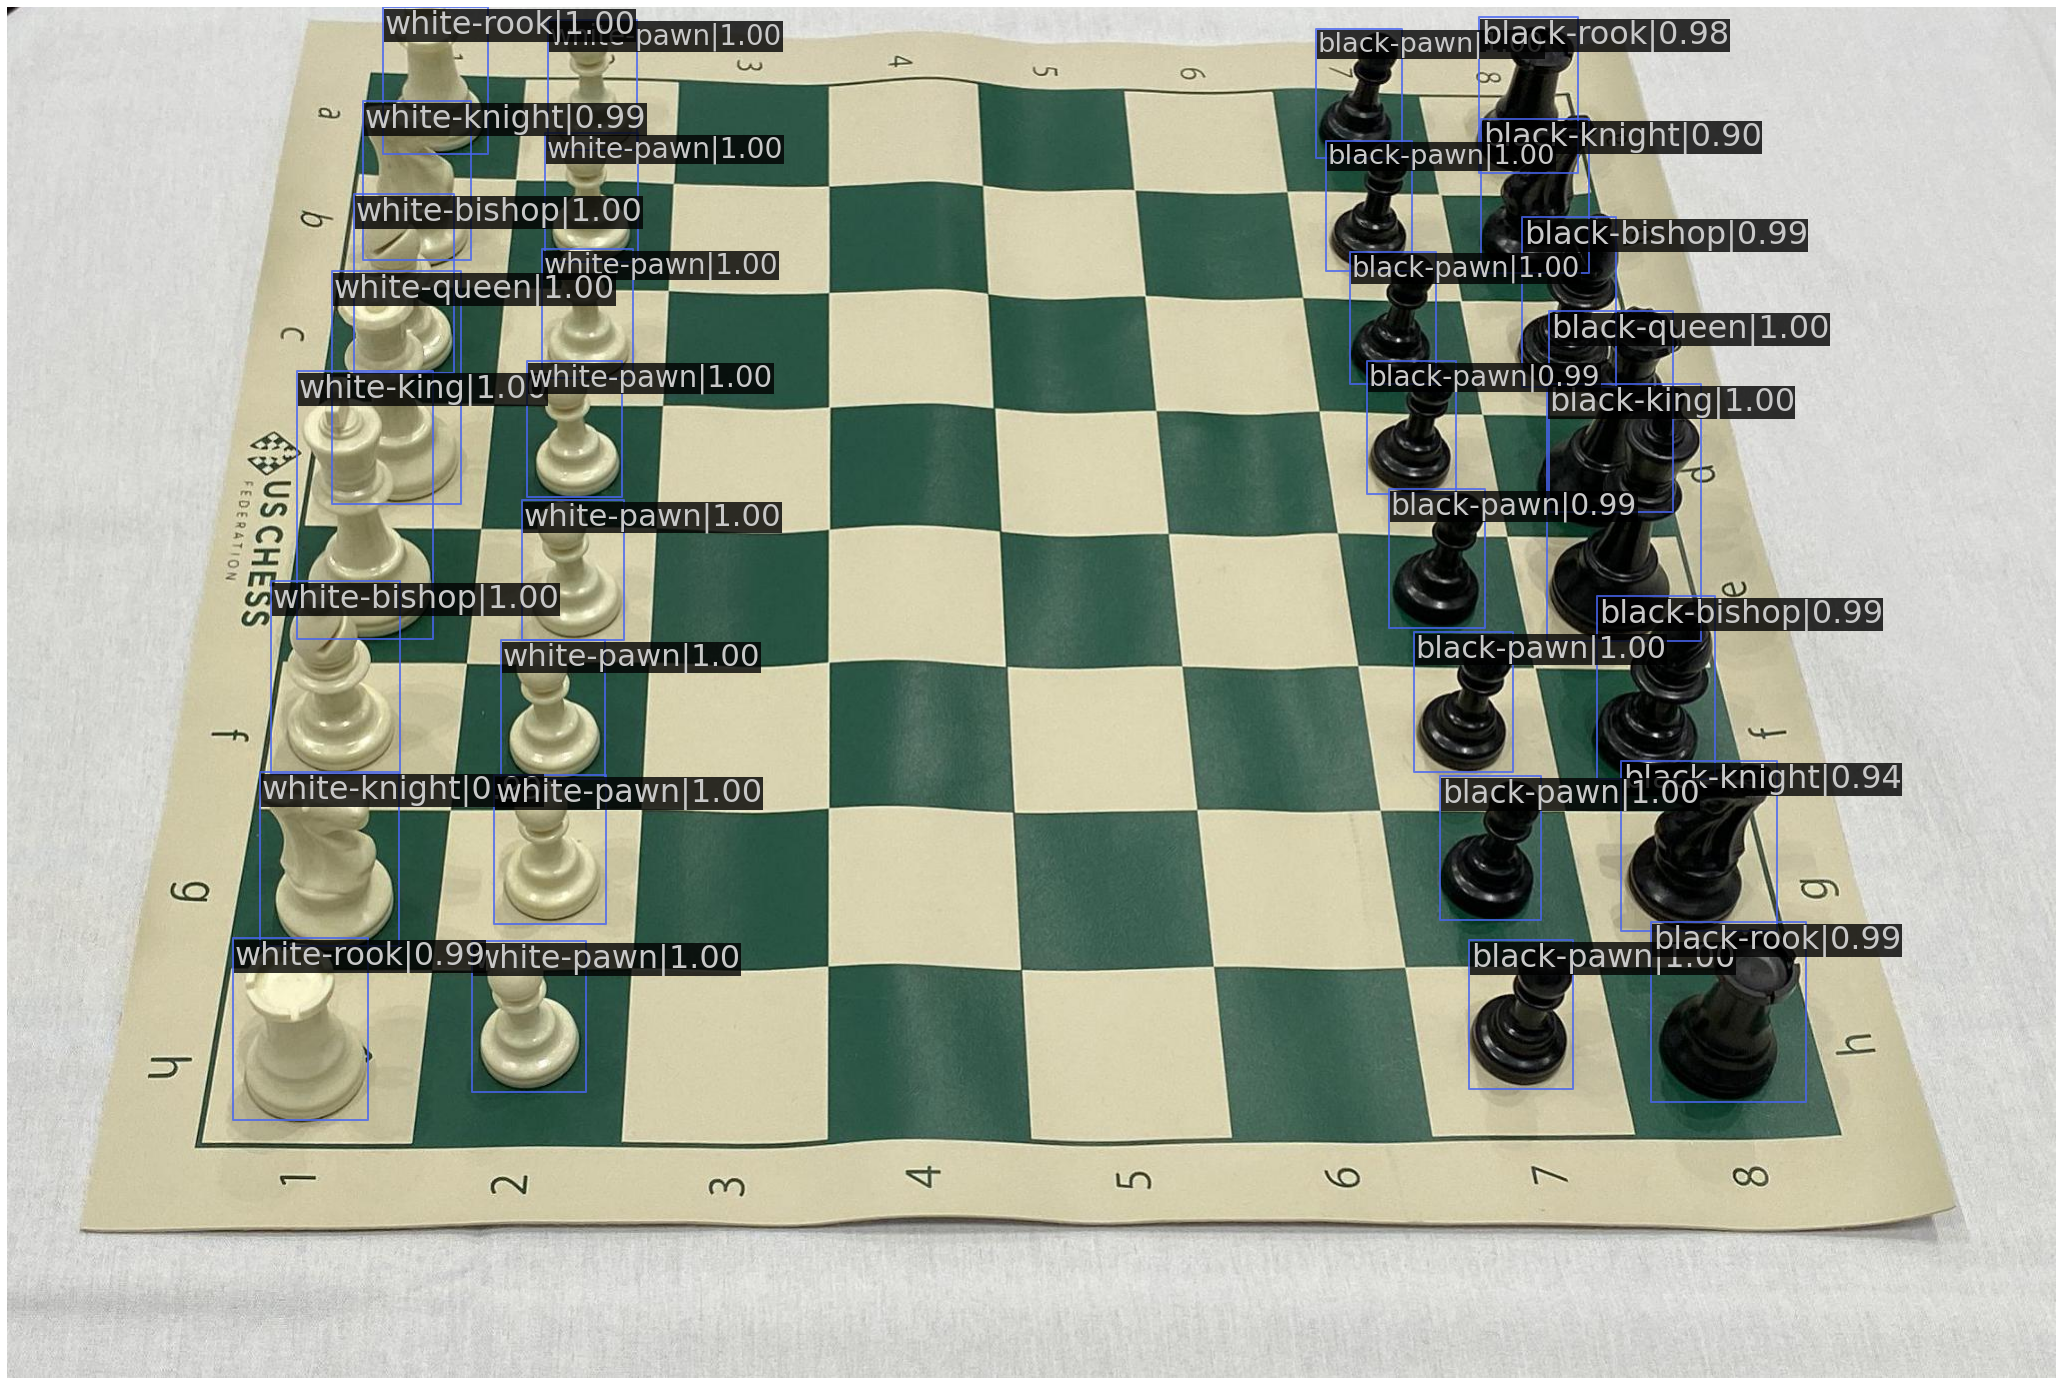

('black-bishop', [0.986516, 0.9837557])
('black-king', [0.9901869])
('black-knight', [0.90148014, 0.89794177, 0.07454677, 0.067042984, 0.054065056])
('black-pawn', [0.99854517, 0.9979558, 0.9977106, 0.99761593, 0.99755585, 0.99726534, 0.99670744, 0.99657553])
('black-queen', [0.99765706])
('black-rook', [0.9733104, 0.96761906, 0.23878531, 0.17267302])
('white-bishop', [0.99813265, 0.9965634])
('white-king', [0.995856])
('white-knight', [0.9917344, 0.9885168])
('white-pawn', [0.9986278, 0.9982292, 0.99820185, 0.9965475, 0.9961761, 0.99531674, 0.9950046, 0.99479103])
('white-queen', [0.9991997, 0.16460858])
('white-rook', [0.9870521, 0.97678804, 0.10698713])


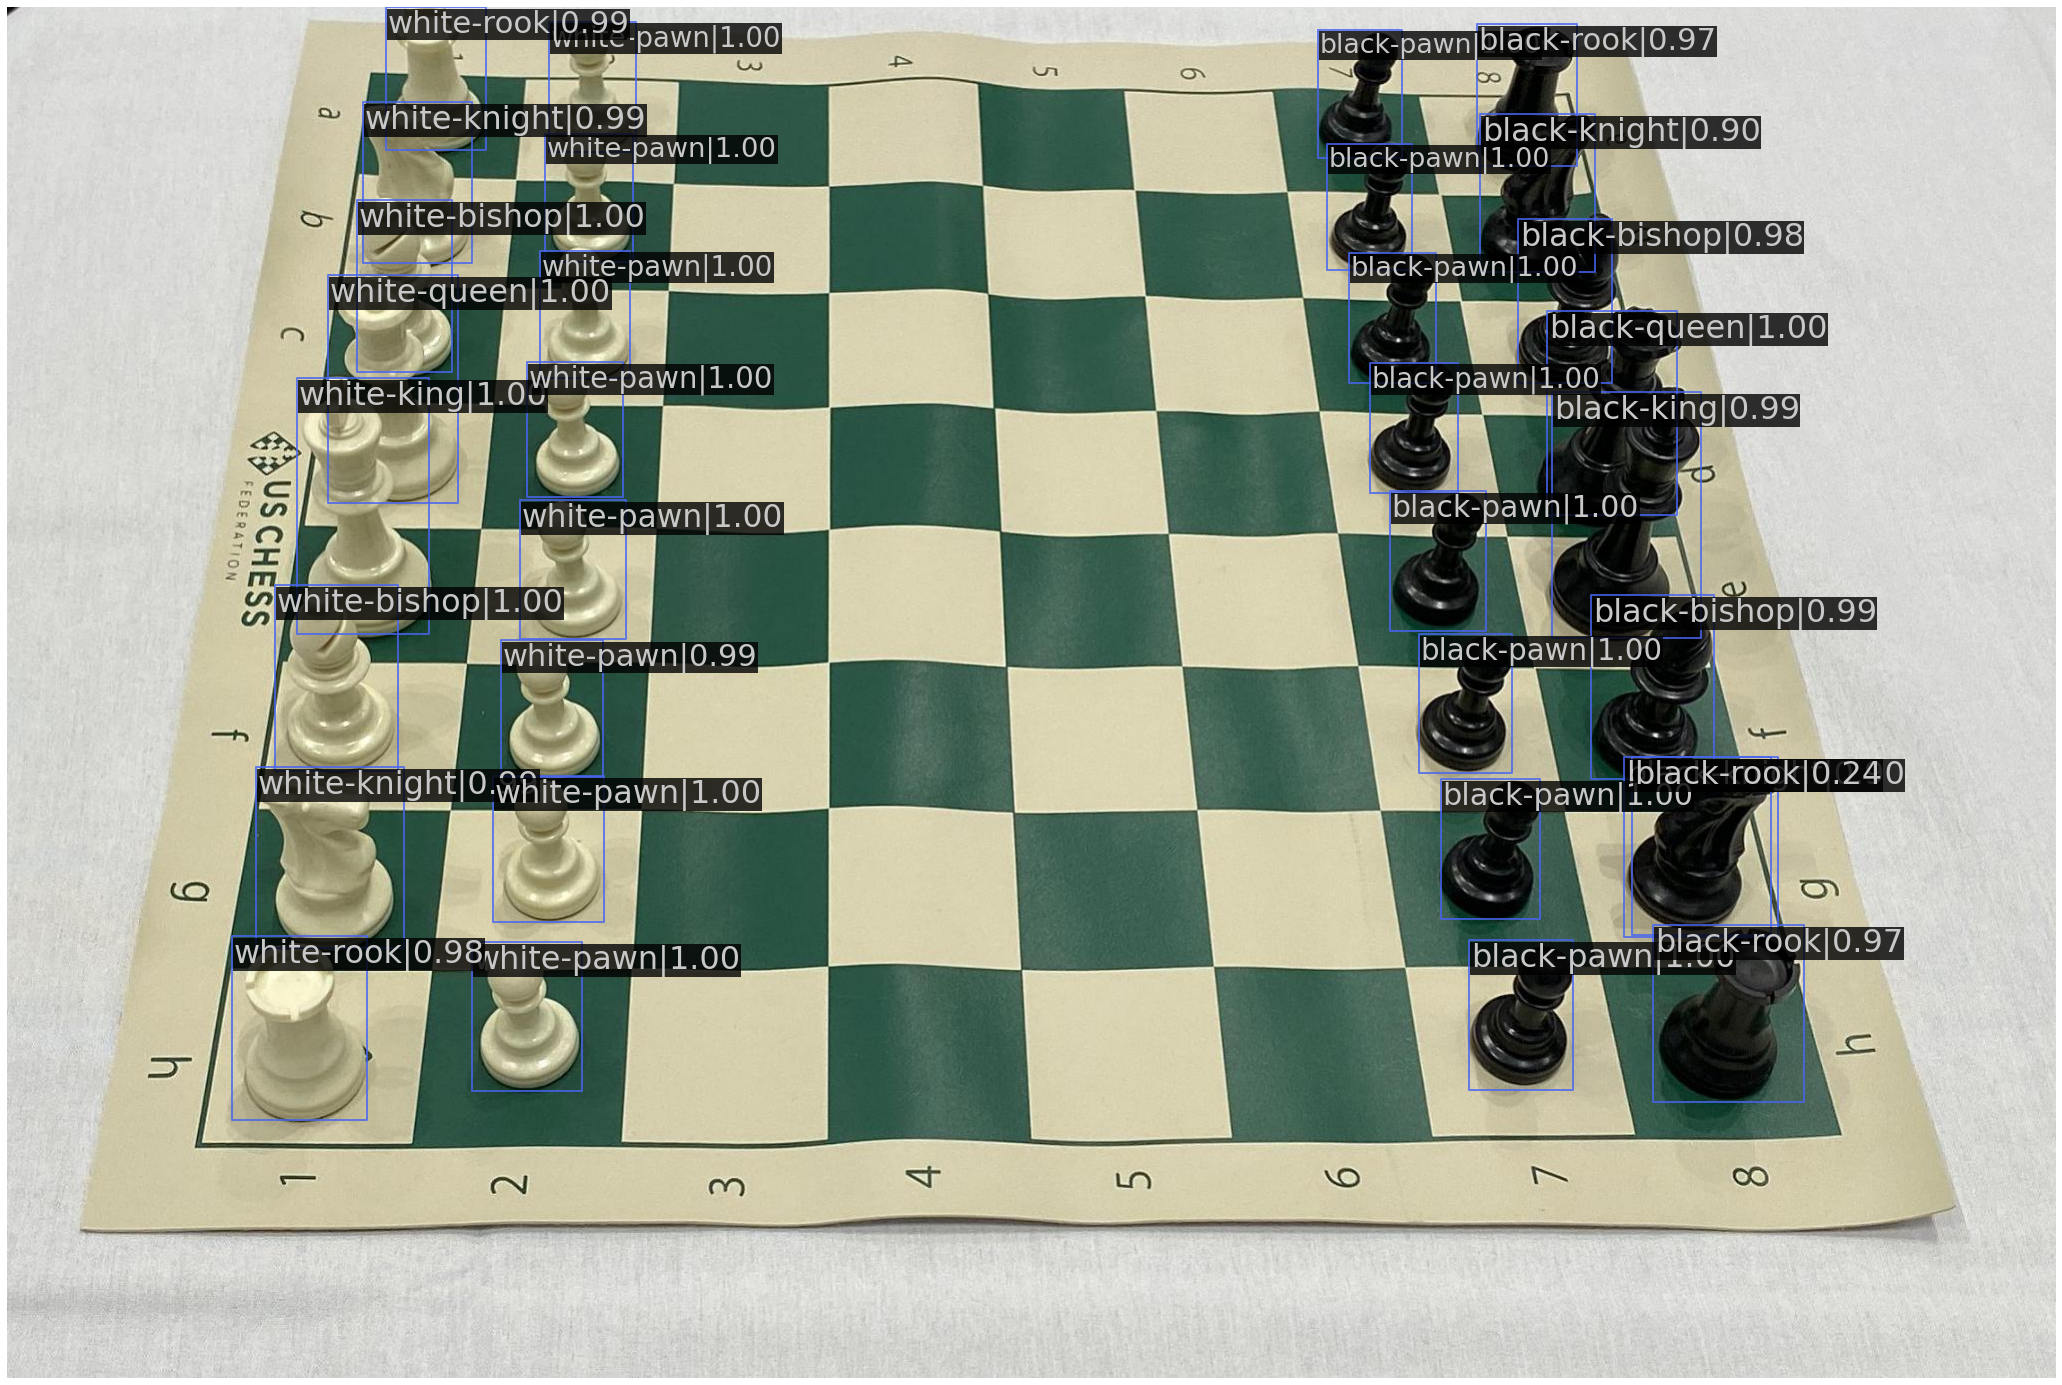

In [11]:
# Show 兩個model inference的結果
random_show_inference(model_pisa,model_nopisa)

In [12]:
fi_pisa.vis.roi_head_bbox_roi_extractor.shape

torch.Size([1000, 256, 7, 7])

In [13]:
for k,feature in fi_pisa.vis.items():
    print(k,"-"*60)
    if isinstance(feature,(tuple,list)):
        for f in feature:
            if isinstance(f,(tuple,list)):
                print([ff.shape for ff in f],"\n")
            else:
                print("\n",f.shape,"\n")
    else:
        print(k,"-"*60,"\n",feature.shape,"\n")

rpn_head ------------------------------------------------------------
[torch.Size([1, 3, 200, 304]), torch.Size([1, 3, 100, 152]), torch.Size([1, 3, 50, 76]), torch.Size([1, 3, 25, 38]), torch.Size([1, 3, 13, 19])] 

[torch.Size([1, 12, 200, 304]), torch.Size([1, 12, 100, 152]), torch.Size([1, 12, 50, 76]), torch.Size([1, 12, 25, 38]), torch.Size([1, 12, 13, 19])] 

roi_head_bbox_roi_extractor ------------------------------------------------------------
roi_head_bbox_roi_extractor ------------------------------------------------------------ 
 torch.Size([1000, 256, 7, 7]) 

roi_head_bbox_head ------------------------------------------------------------

 torch.Size([1000, 14]) 


 torch.Size([1000, 52]) 



In [14]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def show_rpn_result(fi,head_number=0,zoom_scale=0,channel=2):
#     head_number: 0- confidense, 1- bias for x,y,w,h 
#     zoom_scale for proposals: 0~4: 200x304, 100x152, 50x76, 25x38, 13x19
#     channel: featuremap channel 3 type of anchors (w:h ratio)
    im=fi.vis.rpn_head[head_number][zoom_scale][0,channel].detach().to("cpu")
    plt.imshow(F.normalize(im))
    plt.colorbar()
def show_rpn_result(fi,head_number=0,zoom_scale=0,channel=2):
#     head_number: 0- confidense, 1- bias for x,y,w,h 
#     zoom_scale for proposals: 0~4: 200x304, 100x152, 50x76, 25x38, 13x19
#     channel: featuremap channel 3 type of anchors (w:h ratio)
    im=fi.vis.roi_head_bbox_roi_extractor [head_number][zoom_scale][0,channel].detach().to("cpu")
    plt.imshow(F.normalize(im))
    plt.colorbar()

可以看到confidence的分布

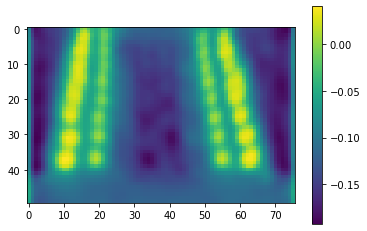

In [25]:
show_rpn_result(fi_pisa,head_number=0,zoom_scale=2,channel=1)

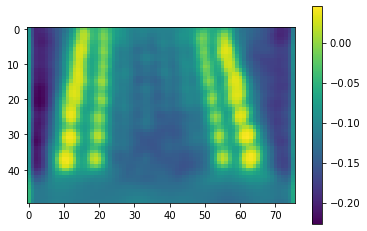

In [26]:
show_rpn_result(fi_nopisa,head_number=0,zoom_scale=2,channel=1)

## Reference

* [PISA] Cao, Y., Chen, K., Loy, C. C., & Lin, D. (2020). Prime sample attention in object detection. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 11583-11591).